# Fine-Tuning Models

Improving your model with fine-tuning the model parameters and selecting the best variables. Introduction of the the bias-variance trade-off.

* K fold cross validation
* K parameter optimization
* Overfitting - underfitting
* Bias - variance trade-off
* Feature engineering, feature selection, GRID, Feature importance

## The Bias-Variance Trade-Off

Main idea: you want to create models that are as **good at prediction** as possible but that are still **applicable to new data**.
* Overfitting
* Underfititng

*Underfitting, overfitting and generalization*: Together, this bundle of concepts related to the balance between underfitting and overfitting is referred to as the **bias-variance trade-off**.

![bias_variance](../files/0401_bias_variance.png "Bias-Variance")

### Underfitting and Overfitting models

![bias_variance_table](../files/0402_bias_variance_table.png "Bias-Variance Table")

### Demonstrating the concept of over and underfitting with kNN

Fit a model with various `k`-params to training set:

![bias_variance_table](../files/0403_training_data_only_99_1.png "Bias-Variance Table")

Now compare the fit to training and test set:

![bias_variance_table](../files/0404_training_data_and_test_99_1.png "Bias-Variance Table")

After examining a very hig and low `k` params let's see one in the middle (50):

![bias_variance_table](../files/0405_training_data_and_test_99_50_1.png "Bias-Variance Table")

Now, as a summary:

![bias_variance_table](../files/0406_over_underfitting.png "Bias-Variance Table")

## Avoiding Under or Overfitting: Cross-Validation (CV)

![CV](../files/0407_cv.png "Cross-Validation")

### Loading our data and packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline

In [2]:
data = pd.read_csv("../files/bank-data.csv", sep=";")
data.drop(data.ix[:,1:10], axis=1, inplace=True)
data.drop("poutcome", axis=1, inplace=True)
n = 4500
sample_yes = data.ix[data.y == "yes"].sample(n=n, replace=False)
sample_no = data.ix[data.y == "no"].sample(n=n, replace=False)
df = pd.concat([sample_yes, sample_no])
df = df.sample(frac=1)       # Shuffle the whole set
X = df.drop('y', axis=1)  
y = df.ix[:, 'y']
y.replace("yes", 1, inplace=True)
y.replace("no", 0, inplace=True)

### Testing Cross-Validation on our Bank Data

In [3]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7200, 10), (7200,), (1800, 10), (1800,))

In [4]:
from sklearn.cross_validation import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [5]:
knn = KNeighborsClassifier()
knn.n_neighbors = 5
knn.fit(X_train, y_train)

scores = cross_val_score(knn, X_train, y_train, cv = 10)
print "Scores: "
print scores
print
print "Average of CV Scores: %.2f" % scores.mean()
print "Std of CV Scores: %.2f" % scores.std()

Scores: 
[ 0.84604716  0.83611111  0.84305556  0.86527778  0.85277778  0.86111111
  0.85833333  0.82638889  0.85138889  0.84979138]

Average of CV Scores: 0.85
Std of CV Scores: 0.01


## Parameter Tuning

### The `k` parameter

In [6]:
# the range of number of neighbors you want to test
n_neighbors = np.arange(1, 100, 2)
 
# here you store the models for each dataset used
train_scores = list()
test_scores = list()
cv_scores = list()
 
# loop through possible n_neighbors and try them out
for n in n_neighbors:
    knn.n_neighbors = n
    knn.fit(X_train, y_train)
    train_scores.append(1 - metrics.accuracy_score(y_train, knn.predict(X_train)))  # this will over-estimate the accuracy
    test_scores.append(1 - metrics.accuracy_score(y_test, knn.predict(X_test)))
    cv_scores.append(1 - cross_val_score(knn, X_train, y_train, cv = 10).mean())  # you take the mean of the CV scores

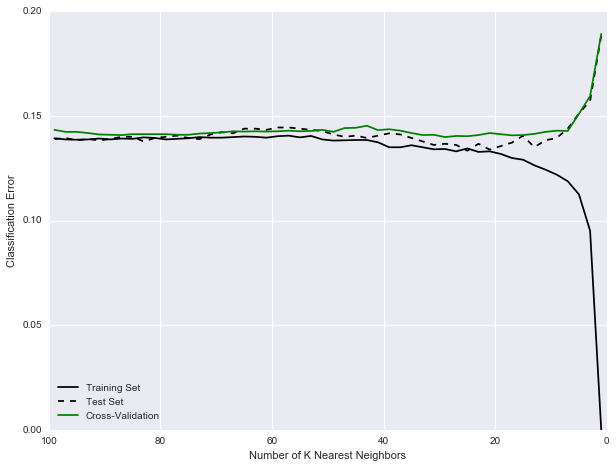

In [7]:
# let's plot the error you get with different values of k
plt.figure(figsize=(10,7.5))
plt.plot(n_neighbors, train_scores, c="black", label="Training Set")
plt.plot(n_neighbors, test_scores, c="black", linestyle="--", label="Test Set")
plt.plot(n_neighbors, cv_scores, c="green", label="Cross-Validation")
plt.xlabel('Number of K Nearest Neighbors')
plt.ylabel('Classification Error')
plt.gca().invert_xaxis()
plt.legend(loc = "lower left")
plt.show()

In [8]:
# what do these different datasets think is the best value of k?
print(
    'The best values of k are:\n' \
    '{} according to the Training Set\n' \
    '{} according to the Test Set and\n' \
    '{} according to Cross-Validation'.format(
        min(n_neighbors[train_scores == min(train_scores)]),
        min(n_neighbors[test_scores == min(test_scores)]),
        min(n_neighbors[cv_scores == min(cv_scores)])        
    )
)    

The best values of k are:
1 according to the Training Set
25 according to the Test Set and
29 according to Cross-Validation


### The `distance` parameter

In [9]:
param = ['euclidean', 'manhattan', 'chebyshev']
score_means = list()
score_stds = list()

for p in param:
    knn = KNeighborsClassifier(n_neighbors= 13, metric=p)
    knn.fit(X_train, y_train)
    score_means.append(cross_val_score(knn, X_train, y_train, cv = 10).mean())
    score_stds.append(cross_val_score(knn, X_train, y_train, cv = 10).std())
    
print "Average of CV Scores: "
print score_means
print
print "Std of CV Scores: "
print score_stds

Average of CV Scores: 
[0.85861182752624488, 0.86083481974738041, 0.85930762415736839]

Std of CV Scores: 
[0.012285851911938902, 0.011412271121424662, 0.013588074655006548]


### The `weights` parameter

In [10]:
param = ['uniform', 'distance']
score_means = list()
score_stds = list()

for p in param:
    knn = KNeighborsClassifier(n_neighbors= 13, weights=p)
    knn.fit(X_train, y_train)
    score_means.append(cross_val_score(knn, X_train, y_train, cv = 10).mean())
    score_stds.append(cross_val_score(knn, X_train, y_train, cv = 10).std())
    
print "Average of CV Scores: "
print score_means
print
print "Std of CV Scores: "
print score_stds

Average of CV Scores: 
[0.85861182752624488, 0.85680704304127819]

Std of CV Scores: 
[0.012285851911938902, 0.013311697579505509]


### Complex param tuning

In [11]:
dists = ['euclidean', 'manhattan', 'chebyshev']
weights = ['uniform', 'distance']
param_tuning = pd.DataFrame(0, index=dists, columns=weights)

for w in weights:
    for d in dists:
        knn = KNeighborsClassifier(n_neighbors= 13, weights=w, metric=d)
        knn.fit(X_train, y_train)
        param_tuning.loc[d,w] = cross_val_score(knn, X_train, y_train, cv = 10).mean()

param_tuning

,uniform,distance
euclidean,0.858612,0.856807
manhattan,0.860835,0.861113
chebyshev,0.859308,0.857780


In [12]:
param_tuning[param_tuning == param_tuning.min().min()]

,uniform,distance
euclidean,NaN,0.856807
manhattan,NaN,NaN
chebyshev,NaN,NaN


### GridSearchCV

In [13]:
from sklearn.grid_search import GridSearchCV

k = np.arange(1, 100, 2)
parameters = {'n_neighbors': k, 'weights': weights, 'metric': dists}
knn = KNeighborsClassifier()
clf = GridSearchCV(knn, parameters, cv=10)
clf.fit(X_train, y_train)

clf.best_score_
clf.best_params_

{'metric': 'manhattan', 'n_neighbors': 43, 'weights': 'distance'}

In [14]:
clf.grid_scores_

[mean: 0.81083, std: 0.01620, params: {'n_neighbors': 1, 'metric': 'euclidean', 'weights': 'uniform'},
 mean: 0.81083, std: 0.01620, params: {'n_neighbors': 1, 'metric': 'euclidean', 'weights': 'distance'},
 mean: 0.84056, std: 0.01156, params: {'n_neighbors': 3, 'metric': 'euclidean', 'weights': 'uniform'},
 mean: 0.83500, std: 0.01222, params: {'n_neighbors': 3, 'metric': 'euclidean', 'weights': 'distance'},
 mean: 0.84903, std: 0.01114, params: {'n_neighbors': 5, 'metric': 'euclidean', 'weights': 'uniform'},
 mean: 0.84431, std: 0.01208, params: {'n_neighbors': 5, 'metric': 'euclidean', 'weights': 'distance'},
 mean: 0.85722, std: 0.01229, params: {'n_neighbors': 7, 'metric': 'euclidean', 'weights': 'uniform'},
 mean: 0.85500, std: 0.01408, params: {'n_neighbors': 7, 'metric': 'euclidean', 'weights': 'distance'},
 mean: 0.85708, std: 0.01413, params: {'n_neighbors': 9, 'metric': 'euclidean', 'weights': 'uniform'},
 mean: 0.85611, std: 0.01580, params: {'n_neighbors': 9, 'metric': 'e

## Feature selection and transformation 

### Normalization / standardization

In [15]:
from sklearn import preprocessing
X_scaled = preprocessing.scale(X)

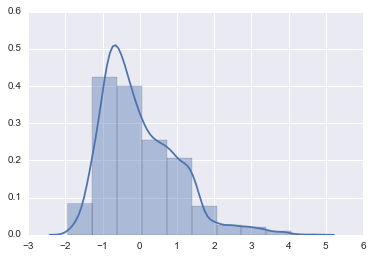

In [16]:
sns.distplot(X_scaled[:,0], bins=10)

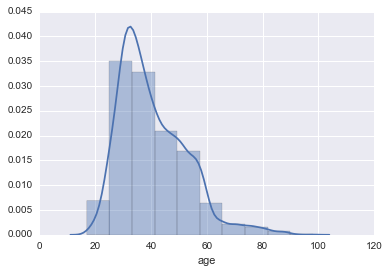

In [17]:
sns.distplot(X.age, bins=10)

In [18]:
print X_scaled[0]
print
print ((X.iloc[0] - X.mean()) / X.std())

[ 0.77805523  0.65825654  2.33696017  0.35374939 -0.44294937 -0.76550176
 -0.93376582 -1.13074553 -0.91764111 -0.42786806]

age               0.778012
duration          0.658220
campaign          2.336830
pdays             0.353730
previous         -0.442925
emp.var.rate     -0.765459
cons.price.idx   -0.933714
cons.conf.idx    -1.130683
euribor3m        -0.917590
nr.employed      -0.427844
dtype: float64


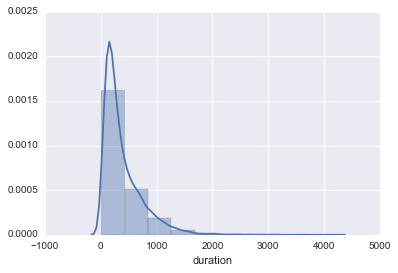

In [19]:
sns.distplot(X.duration, bins=10)

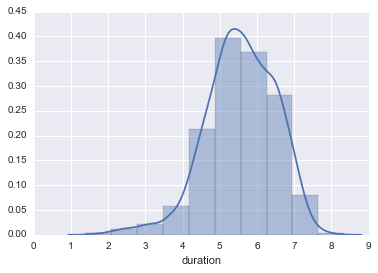

In [20]:
sns.distplot(np.log(X.duration), bins=10)

### Feature Selection

#### Removing features with low variance

In [21]:
X.var()

age                  147.453844
duration          128147.352353
campaign               5.861196
pdays              97500.066603
previous               0.483899
emp.var.rate           2.979204
cons.price.idx         0.401524
cons.conf.idx         28.392509
euribor3m              3.573198
nr.employed         7563.254240
dtype: float64

In [22]:
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=(1))
opt_X = sel.fit_transform(X)

In [23]:
opt_X = pd.DataFrame(opt_X)
opt_X.shape

(9000, 8)

In [24]:
opt_X.head()

,0,1,2,3,4,5,6,7
0,50.0,623.0,8.0,999.0,-1.8,-46.2,1.250,5099.1
1,34.0,230.0,1.0,999.0,1.1,-36.4,4.859,5191.0
2,49.0,282.0,1.0,999.0,1.1,-36.4,4.860,5191.0
3,58.0,901.0,1.0,999.0,-1.8,-46.2,1.250,5099.1
4,42.0,172.0,2.0,999.0,-0.1,-42.0,4.076,5195.8


### Univariate feature selection

Selecting the best features based on univariate statistical tests.
* For regression: f_regression
* For classification: chi2 (non-negative) or f_classif


In [25]:
X.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
35409,50,623,8,999,0,-1.8,92.893,-46.2,1.250,5099.1
2715,34,230,1,999,0,1.1,93.994,-36.4,4.859,5191.0
3334,49,282,1,999,0,1.1,93.994,-36.4,4.860,5191.0
35008,58,901,1,999,0,-1.8,92.893,-46.2,1.250,5099.1
26925,42,172,2,999,0,-0.1,93.200,-42.0,4.076,5195.8


In [26]:
from sklearn.feature_selection import SelectKBest

X_new = SelectKBest(k=4).fit_transform(X, y)
X_new.shape

(9000, 4)

In [27]:
X_new = pd.DataFrame(X_new)
X_new.head()

,0,1,2,3
0,623.0,-1.8,1.250,5099.1
1,230.0,1.1,4.859,5191.0
2,282.0,1.1,4.860,5191.0
3,901.0,-1.8,1.250,5099.1
4,172.0,-0.1,4.076,5195.8


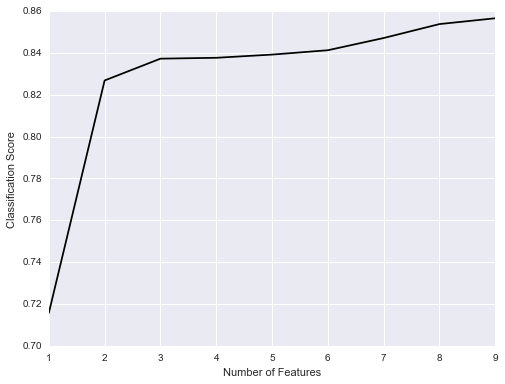

In [28]:
feature_num = np.arange(1,10)
knn = KNeighborsClassifier(n_neighbors=29, metric='manhattan', weights='distance')
scores = list()

for num in feature_num:
    X_new = SelectKBest(k=num).fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=0)
    scores.append(cross_val_score(knn, X_train, y_train, cv = 10).mean())
    
plt.figure(figsize=(8,6))
plt.plot(feature_num, scores, c="black")
plt.xlabel('Number of Features')
plt.ylabel('Classification Score')
plt.show()

## Feature engineering

* aggregation: Min/Max as 2 features we could substract to get interval
* decomposation: dates and times, just use hour of the day

## Final Classification Model

In [29]:
data = pd.read_csv("../files/bank-data.csv", sep=";")
data.drop(data.ix[:,1:10], axis=1, inplace=True)
data.drop("poutcome", axis=1, inplace=True)
n = 4500
sample_yes = data.ix[data.y == "yes"].sample(n=n, replace=False)
sample_no = data.ix[data.y == "no"].sample(n=n, replace=False)
df = pd.concat([sample_yes, sample_no])
df = df.sample(frac=1)       # Shuffle the whole set
X = df.drop('y', axis=1)  
y = df.ix[:, 'y']
y.replace("yes", 1, inplace=True)
y.replace("no", 0, inplace=True)

In [30]:
X_best = X
X_best['duration'] = X_best['duration'].apply(lambda x: np.log(x))
X_best = preprocessing.scale(X_best)

In [31]:
X_best = SelectKBest(k=5).fit_transform(X_best, y)
X_best.shape

(9000, 5)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_best, y, test_size=0.2, random_state=0)

In [33]:
k = np.arange(1, 100, 2)
parameters = {'n_neighbors': k, 'weights': weights, 'metric': dists}
knn = KNeighborsClassifier()
clf = GridSearchCV(knn, parameters, cv=10)
clf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99]), 'metric': ['euclidean', 'manhattan', 'chebyshev'], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [34]:
print clf.best_score_
print clf.best_params_

0.883055555556
{'n_neighbors': 11, 'metric': 'manhattan', 'weights': 'uniform'}
